In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import random
import torch

DATASET_NAME = 'CIFAR10'    # CIFAR10, CIFAR100
DATASET_TYPE = 'custom'   # baseline, custom
REWEIGHT = True
EPOCHS = 200
BATCH_SIZE = 128
ENABLE_TPU = True
LEARNING_RATE = 0.1   # 0.15(default), 0.1
MANUAL_SEED = 0

# CIFAR-10-C
if DATASET_NAME=='CIFAR10':
    dataset_dir = '/kaggle/input/cifar-c'
    print(os.listdir(dataset_dir))
    # Define the path to the subdirectory
    sub_dir = os.path.join(dataset_dir, 'CIFAR-10-C')
    # List contents of the subdirectory
    print(os.listdir(sub_dir))
elif DATASET_NAME=='CIFAR100':
    # CIFAR-100-C
    dataset_dir = '/kaggle/input/cifar-100-c'
    print(os.listdir(dataset_dir))
else:
    raise ValueError(f'Dataset {DATASET_NAME} not supported')
    

print(f'Hyperparameters:\n\tDataset: {DATASET_NAME}\n\tType: {DATASET_TYPE}\n\tEpochs: {EPOCHS}\n\tTPU Enabled: {ENABLE_TPU}')

['CIFAR-10-C']
['motion_blur.npy', 'speckle_noise.npy', 'jpeg_compression.npy', 'impulse_noise.npy', 'defocus_blur.npy', 'brightness.npy', 'elastic_transform.npy', 'snow.npy', 'labels.npy', 'gaussian_blur.npy', 'frost.npy', 'zoom_blur.npy', 'spatter.npy', 'fog.npy', 'gaussian_noise.npy', 'contrast.npy', 'saturate.npy', 'shot_noise.npy', 'pixelate.npy', 'glass_blur.npy']
Hyperparameters:
	Dataset: CIFAR10
	Type: custom
	Epochs: 200
	TPU Enabled: True


In [2]:
!pip install torchmetrics
!git clone https://github.com/EkagraGupta/MasterArbeit.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 0.0/926.4 kB ? eta -:--:--

     ━━━━━━━━━━━━━━━━━━━━━╸━━━━━━━━━━━━━━━━ 532.5/926.4 kB 16.5 MB/s eta 0:00:01

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 14.5 MB/s eta 0:00:00



[notice] A new release of pip is available: 23.0.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Cloning into 'MasterArbeit'...


remote: Enumerating objects: 3757, done.


remote: Counting objects: 100% (571/571), done.


remote: Compressing objects: 100% (236/236), done.


remote: Total 3757 (delta 340), reused 563 (delta 335), pack-reused 3186 (from 1)
Receiving objects: 100% (3757/3757), 1.12 GiB | 37.56 MiB/s, done.


Resolving deltas: 100% (2095/2095), done.


Updating files: 100% (299/299), done.


In [3]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
    
g = torch.Generator()
g.manual_seed(MANUAL_SEED)

In [4]:
# Import statements
import torch
import random
import torchvision
import torchvision.transforms as transforms
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import CosineAnnealingLR
from torchvision.transforms import TrivialAugmentWide
from torch.utils.data import Dataset
from torch.utils.data import ConcatDataset
import os

# Define the device
tpu = ENABLE_TPU

if tpu == True:
    print('TPU is Enabled')
    import torch_xla
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
else:
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')  #intend here for else


class CustomDataset(Dataset):
    def __init__(self, np_images, original_dataset, resize):
        # Load images
        self.images = torch.from_numpy(np_images).permute(0, 3, 1, 2) / 255
         #Normalize the images
        #transform_test = transforms.Compose([
            #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        #])
        #self.images = transform_test(self.images)
        #if resize == True:
            #self.images = transforms.Resize(224, antialias=True)(self.images)
        
        # Extract labels from the original PyTorch dataset
        self.labels = [label for _, label in original_dataset]

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, index):
        # Get image and label for the given index
        image = self.images[index]
        label = self.labels[index]

        return image, label

# Define the function to load corrupted datasets separately
def load_data_c_separately(dataset, testset, resize, test_transforms, batch_size):
    corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']
    np.asarray(corruptions)
    c_datasets = {}
    for corruption in corruptions:
        if dataset == 'CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
            np_data_c = np.array(np.array_split(np_data_c, 5))
            custom_dataset = CustomDataset(np_data_c[0], testset, resize)  # Load only one split for now
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)
            c_datasets[corruption] = custom_dataloader
        else:
            print('No corrupted benchmark available other than CIFAR10-c.')

    return c_datasets


# Load corrupted datasets
#corrupted_datasets = load_data_c(dataset='CIFAR10', testset=testset, resize=True, 
                                 #test_transforms=None, subset=False, subsetsize=None)

# Transformations for training and test sets
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),  
    TrivialAugmentWide(),
    transforms.ToTensor(),
])
transform_test = transforms.Compose([
    transforms.ToTensor(),
])

batch_size = BATCH_SIZE

print(f'Loading {DATASET_NAME}...\n')
if DATASET_NAME=='CIFAR10':
#     Use CIFAR-10 dataset for training
    num_classes = 10    # CIFAR-10
    baseline_trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-10 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
elif DATASET_NAME=='CIFAR100':
    # # Use CIFAR-100 dataset for training
    num_classes = 100   # CIFAR-100
    baseline_trainset = torchvision.datasets.CIFAR100(root='./data', train=True,
                                            download=True, transform=transform_train)
    baseline_trainloader = torch.utils.data.DataLoader(baseline_trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)

    # Use CIFAR-100 dataset for testing
    baseline_testset = torchvision.datasets.CIFAR100(root='./data', train=False,
                                           download=True, transform=transform_test)
    baseline_testloader = torch.utils.data.DataLoader(baseline_testset, batch_size=batch_size,
                                             shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
    
%cd /kaggle/working/MasterArbeit
!git checkout add-randomerasing
from augment_dataset import create_transforms, load_data
# from compute_loss import soft_loss

"""
 Create the transformations based on the provided flags:
 - If all flags (random_cropping, aggressive_augmentation, and custom) are False:
   No augmentation other than default preprocessing is applied.
 - If random_cropping (rc) is True and the others (aa and custom) are False:
   Only random cropping is applied.
 - If random_cropping (rc) and aggressive_augmentation (aa) are True, and custom is False:
   Random cropping and conventional aggressive augmentation techniques (TA) are applied.
 - If all three flags (rc, aa, custom) are True:
   Random cropping and soft augmentation techniques (TA) are applied.
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is False:
   Only conventional aggressive augmentation techniques (TA) are applied (no soft labels).
 - If random_cropping (rc) is False, aggressive_augmentation (aa) is True, and custom is True:
   Aggressive augmentation (TA) is applied with soft labeling.
"""

transforms_preprocess, transforms_augmentation = create_transforms(random_cropping=False, aggressive_augmentation=False, custom=True, dataset_name=DATASET_NAME)
custom_trainset, custom_testset = load_data(transforms_preprocess=transforms_preprocess, transforms_augmentation=transforms_augmentation, dataset_name=DATASET_NAME)
custom_trainloader = torch.utils.data.DataLoader(custom_trainset, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
custom_testloader = torch.utils.data.DataLoader(custom_testset, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True, worker_init_fn=seed_worker, generator=g)
%cd

classes = baseline_trainset.classes


TPU is Enabled


/usr/local/lib/python3.10/site-packages/torch_xla/__init__.py:202: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


E0000 00:00:1732956935.149903      77 common_lib.cc:818] Could not set metric server port: INVALID_ARGUMENT: Could not find SliceBuilder port 8471 in any of the 0 ports provided in `tpu_process_addresses`="local"
=== Source Location Trace: ===
learning/45eac/tfrc/runtime/common_lib.cc:483


Loading CIFAR10...



  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:50, 362027.29it/s]

  0%|          | 229376/170498071 [00:00<04:11, 676688.23it/s]

  1%|          | 917504/170498071 [00:00<01:21, 2089037.36it/s]

  2%|▏         | 2785280/170498071 [00:00<00:25, 6453096.71it/s]

  3%|▎         | 5537792/170498071 [00:00<00:13, 12204285.66it/s]

  5%|▌         | 9109504/170498071 [00:00<00:08, 18794879.96it/s]

  7%|▋         | 12746752/170498071 [00:00<00:06, 23817404.18it/s]

 10%|▉         | 16220160/170498071 [00:01<00:06, 23524939.49it/s]

 12%|█▏        | 19922944/170498071 [00:01<00:05, 26817838.42it/s]

 14%|█▎        | 23166976/170498071 [00:01<00:05, 27888674.95it/s]

 16%|█▌        | 26804224/170498071 [00:01<00:04, 30235891.52it/s]

 18%|█▊        | 30375936/170498071 [00:01<00:04, 31769557.59it/s]

 20%|█▉        | 34078720/170498071 [00:01<00:04, 33276633.96it/s]

 22%|██▏       | 37486592/170498071 [00:01<00:04, 33103174.62it/s]

 24%|██▍       | 41058304/170498071 [00:01<00:03, 33845641.33it/s]

 26%|██▌       | 44498944/170498071 [00:01<00:03, 32345391.71it/s]

 28%|██▊       | 47939584/170498071 [00:02<00:03, 32683539.26it/s]

 30%|███       | 51249152/170498071 [00:02<00:03, 30194234.01it/s]

 32%|███▏      | 54624256/170498071 [00:02<00:03, 31146110.86it/s]

 34%|███▍      | 58261504/170498071 [00:02<00:03, 32584937.65it/s]

 36%|███▋      | 61964288/170498071 [00:02<00:03, 33850425.71it/s]

 38%|███▊      | 65404928/170498071 [00:02<00:03, 32722902.56it/s]

 41%|████      | 69107712/170498071 [00:02<00:02, 33932912.61it/s]

 43%|████▎     | 72777728/170498071 [00:02<00:02, 34711564.28it/s]

 45%|████▍     | 76283904/170498071 [00:02<00:03, 31190030.59it/s]

 47%|████▋     | 79527936/170498071 [00:03<00:02, 31256115.67it/s]

 49%|████▊     | 82837504/170498071 [00:03<00:02, 31753379.54it/s]

 51%|█████     | 86507520/170498071 [00:03<00:02, 33135135.35it/s]

 53%|█████▎    | 90177536/170498071 [00:03<00:02, 34159118.85it/s]

 55%|█████▍    | 93650944/170498071 [00:03<00:02, 34312375.86it/s]

 57%|█████▋    | 97124352/170498071 [00:03<00:02, 33569366.08it/s]

 59%|█████▉    | 100499456/170498071 [00:03<00:02, 33540316.91it/s]

 61%|██████    | 104071168/170498071 [00:03<00:01, 33843338.07it/s]

 63%|██████▎   | 107479040/170498071 [00:03<00:01, 32889665.61it/s]

 65%|██████▍   | 110788608/170498071 [00:03<00:01, 32752809.49it/s]

 67%|██████▋   | 114130944/170498071 [00:04<00:01, 32392785.69it/s]

 69%|██████▉   | 117506048/170498071 [00:04<00:01, 31958015.31it/s]

 71%|███████   | 120717312/170498071 [00:04<00:01, 31413145.19it/s]

 73%|███████▎  | 124354560/170498071 [00:04<00:01, 32836352.44it/s]

 75%|███████▌  | 127991808/170498071 [00:04<00:01, 33856883.36it/s]

 77%|███████▋  | 131563520/170498071 [00:04<00:01, 34385718.61it/s]

 79%|███████▉  | 135036928/170498071 [00:04<00:01, 33300369.06it/s]

 81%|████████▏ | 138706944/170498071 [00:04<00:00, 34264896.11it/s]

 83%|████████▎ | 142180352/170498071 [00:04<00:00, 34366034.83it/s]

 85%|████████▌ | 145653760/170498071 [00:05<00:00, 32160620.97it/s]

 87%|████████▋ | 148930560/170498071 [00:05<00:00, 31897614.92it/s]

 89%|████████▉ | 152272896/170498071 [00:05<00:00, 32329992.22it/s]

 91%|█████████ | 155549696/170498071 [00:05<00:00, 31388686.80it/s]

 93%|█████████▎| 159219712/170498071 [00:05<00:00, 32886786.46it/s]

 95%|█████████▌| 162824192/170498071 [00:05<00:00, 33798896.28it/s]

 97%|█████████▋| 166232064/170498071 [00:05<00:00, 32625890.97it/s]

 99%|█████████▉| 169607168/170498071 [00:05<00:00, 32915240.31it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29661582.86it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


Files already downloaded and verified


/kaggle/working/MasterArbeit


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


branch 'add-randomerasing' set up to track 'origin/add-randomerasing'.
Switched to a new branch 'add-randomerasing'


/usr/local/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:57, 356879.55it/s]

  0%|          | 229376/170498071 [00:00<04:14, 670092.13it/s]

  1%|          | 917504/170498071 [00:00<01:22, 2067249.64it/s]

  2%|▏         | 2686976/170498071 [00:00<00:27, 6146115.49it/s]

  3%|▎         | 5472256/170498071 [00:00<00:13, 12035879.44it/s]

  5%|▌         | 9076736/170498071 [00:00<00:08, 18744818.48it/s]

  7%|▋         | 12615680/170498071 [00:00<00:06, 23478309.93it/s]

  9%|▉         | 16187392/170498071 [00:01<00:05, 27010462.27it/s]

 11%|█▏        | 19333120/170498071 [00:01<00:06, 24976329.98it/s]

 13%|█▎        | 22839296/170498071 [00:01<00:05, 27683041.02it/s]

 16%|█▌        | 26476544/170498071 [00:01<00:04, 30039022.38it/s]

 17%|█▋        | 29655040/170498071 [00:01<00:04, 29953808.32it/s]

 19%|█▉        | 32800768/170498071 [00:01<00:04, 30163351.53it/s]

 21%|██▏       | 36438016/170498071 [00:01<00:04, 31877058.71it/s]

 24%|██▎       | 40075264/170498071 [00:01<00:03, 33161715.78it/s]

 26%|██▌       | 43712512/170498071 [00:01<00:03, 33957410.55it/s]

 28%|██▊       | 47218688/170498071 [00:02<00:03, 32440705.17it/s]

 30%|██▉       | 50692096/170498071 [00:02<00:03, 32962086.61it/s]

 32%|███▏      | 54263808/170498071 [00:02<00:03, 33682313.60it/s]

 34%|███▍      | 57671680/170498071 [00:02<00:03, 30121280.60it/s]

 36%|███▌      | 61276160/170498071 [00:02<00:03, 31707810.05it/s]

 38%|███▊      | 64847872/170498071 [00:02<00:03, 32804089.19it/s]

 40%|████      | 68452352/170498071 [00:02<00:03, 33716729.33it/s]

 42%|████▏     | 71958528/170498071 [00:02<00:02, 34082668.67it/s]

 44%|████▍     | 75431936/170498071 [00:02<00:02, 33436315.86it/s]

 46%|████▋     | 79101952/170498071 [00:02<00:02, 34363767.82it/s]

 48%|████▊     | 82575360/170498071 [00:03<00:02, 30054431.48it/s]

 50%|█████     | 86016000/170498071 [00:03<00:02, 31215560.42it/s]

 52%|█████▏    | 89358336/170498071 [00:03<00:02, 31066809.64it/s]

 55%|█████▍    | 92995584/170498071 [00:03<00:02, 32519728.63it/s]

 57%|█████▋    | 96567296/170498071 [00:03<00:02, 33403985.82it/s]

 59%|█████▉    | 100204544/170498071 [00:03<00:02, 34252174.95it/s]

 61%|██████    | 103677952/170498071 [00:03<00:01, 34017414.48it/s]

 63%|██████▎   | 107315200/170498071 [00:03<00:01, 33160732.41it/s]

 65%|██████▍   | 110657536/170498071 [00:03<00:01, 32564961.35it/s]

 67%|██████▋   | 114163712/170498071 [00:04<00:01, 32186480.09it/s]

 69%|██████▉   | 117571584/170498071 [00:04<00:01, 30589838.46it/s]

 71%|███████   | 121176064/170498071 [00:04<00:01, 32054108.22it/s]

 73%|███████▎  | 124780544/170498071 [00:04<00:01, 33148297.31it/s]

 75%|███████▌  | 128417792/170498071 [00:04<00:01, 34066794.25it/s]

 77%|███████▋  | 131858432/170498071 [00:04<00:01, 33691663.89it/s]

 79%|███████▉  | 135495680/170498071 [00:04<00:01, 32834572.78it/s]

 82%|████████▏ | 139100160/170498071 [00:04<00:00, 33730022.14it/s]

 84%|████████▎ | 142508032/170498071 [00:04<00:00, 31001538.73it/s]

 85%|████████▌ | 145686528/170498071 [00:05<00:00, 31092440.41it/s]

 88%|████████▊ | 149356544/170498071 [00:05<00:00, 32632747.96it/s]

 90%|████████▉ | 152666112/170498071 [00:05<00:00, 32108227.35it/s]

 91%|█████████▏| 155910144/170498071 [00:05<00:00, 32090387.47it/s]

 93%|█████████▎| 159154176/170498071 [00:05<00:00, 31995469.49it/s]

 95%|█████████▌| 162398208/170498071 [00:05<00:00, 31819492.27it/s]

 97%|█████████▋| 165609472/170498071 [00:05<00:00, 31771397.22it/s]

 99%|█████████▉| 168853504/170498071 [00:05<00:00, 31895392.76it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 29315648.52it/s]

Extracting ./data/train/cifar-10-python.tar.gz to ./data/train


  0%|          | 0/170498071 [00:00<?, ?it/s]

  0%|          | 65536/170498071 [00:00<07:59, 355099.50it/s]

  0%|          | 229376/170498071 [00:00<04:17, 661108.91it/s]

  0%|          | 524288/170498071 [00:00<02:05, 1352270.55it/s]

  1%|          | 1212416/170498071 [00:00<00:56, 3020232.02it/s]

  2%|▏         | 2654208/170498071 [00:00<00:25, 6461151.23it/s]

  3%|▎         | 5144576/170498071 [00:00<00:13, 11994076.28it/s]

  5%|▍         | 8519680/170498071 [00:00<00:08, 18467785.02it/s]

  7%|▋         | 11862016/170498071 [00:00<00:06, 22925557.15it/s]

  9%|▊         | 14712832/170498071 [00:01<00:06, 24575858.28it/s]

 11%|█         | 18186240/170498071 [00:01<00:05, 27510923.53it/s]

 12%|█▏        | 21233664/170498071 [00:01<00:05, 28027247.51it/s]

 14%|█▍        | 24608768/170498071 [00:01<00:04, 29703429.14it/s]

 16%|█▋        | 27721728/170498071 [00:01<00:04, 30116005.47it/s]

 18%|█▊        | 31195136/170498071 [00:01<00:04, 31481927.69it/s]

 20%|██        | 34570240/170498071 [00:01<00:04, 32111629.85it/s]

 22%|██▏       | 37814272/170498071 [00:01<00:04, 31979348.86it/s]

 24%|██▍       | 41025536/170498071 [00:01<00:04, 31953640.84it/s]

 26%|██▌       | 44236800/170498071 [00:02<00:04, 29105359.60it/s]

 28%|██▊       | 47382528/170498071 [00:02<00:04, 29750943.36it/s]

 30%|██▉       | 50561024/170498071 [00:02<00:03, 30270120.03it/s]

 32%|███▏      | 54198272/170498071 [00:02<00:03, 32026783.39it/s]

 34%|███▍      | 57671680/170498071 [00:02<00:03, 31338608.93it/s]

 36%|███▌      | 60850176/170498071 [00:02<00:03, 31112911.05it/s]

 38%|███▊      | 63995904/170498071 [00:02<00:03, 31200623.67it/s]

 39%|███▉      | 67141632/170498071 [00:02<00:03, 31225875.85it/s]

 41%|████▏     | 70352896/170498071 [00:02<00:03, 31435442.71it/s]

 43%|████▎     | 73531392/170498071 [00:02<00:03, 31498329.41it/s]

 45%|████▌     | 76840960/170498071 [00:03<00:02, 31961460.52it/s]

 47%|████▋     | 80248832/170498071 [00:03<00:02, 32535140.21it/s]

 49%|████▉     | 83525632/170498071 [00:03<00:02, 32321295.17it/s]

 51%|█████     | 86900736/170498071 [00:03<00:02, 31112162.39it/s]

 53%|█████▎    | 90472448/170498071 [00:03<00:02, 32400099.02it/s]

 55%|█████▌    | 94273536/170498071 [00:03<00:02, 34023850.52it/s]

 57%|█████▋    | 97714176/170498071 [00:03<00:02, 30883013.99it/s]

 59%|█████▉    | 101056512/170498071 [00:03<00:02, 31573681.15it/s]

 61%|██████▏   | 104726528/170498071 [00:03<00:01, 33018706.12it/s]

 64%|██████▎   | 108429312/170498071 [00:04<00:01, 34146730.32it/s]

 66%|██████▌   | 111902720/170498071 [00:04<00:01, 33191557.43it/s]

 68%|██████▊   | 115277824/170498071 [00:04<00:01, 32341777.44it/s]

 70%|██████▉   | 118915072/170498071 [00:04<00:01, 33475635.48it/s]

 72%|███████▏  | 122519552/170498071 [00:04<00:01, 33410610.85it/s]

 74%|███████▍  | 125894656/170498071 [00:04<00:01, 33170212.21it/s]

 76%|███████▌  | 129236992/170498071 [00:04<00:01, 32679247.16it/s]

 78%|███████▊  | 132513792/170498071 [00:04<00:01, 32649233.80it/s]

 80%|███████▉  | 135790592/170498071 [00:04<00:01, 31756586.84it/s]

 82%|████████▏ | 139427840/170498071 [00:04<00:00, 33078149.49it/s]

 84%|████████▎ | 142770176/170498071 [00:05<00:00, 32906344.88it/s]

 86%|████████▌ | 146079744/170498071 [00:05<00:00, 32409643.76it/s]

 88%|████████▊ | 149389312/170498071 [00:05<00:00, 32544357.51it/s]

 90%|████████▉ | 152666112/170498071 [00:05<00:00, 30786510.78it/s]

 91%|█████████▏| 155811840/170498071 [00:05<00:00, 30161256.69it/s]

 93%|█████████▎| 158924800/170498071 [00:05<00:00, 30375608.95it/s]

 95%|█████████▌| 162004992/170498071 [00:05<00:00, 30438388.14it/s]

 97%|█████████▋| 165085184/170498071 [00:05<00:00, 30151007.75it/s]

 99%|█████████▊| 168329216/170498071 [00:05<00:00, 30797212.32it/s]

100%|██████████| 170498071/170498071 [00:05<00:00, 28568206.35it/s]

Extracting ./data/test/cifar-10-python.tar.gz to ./data/test


/root


/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:393: UserWarning: This is now an optional IPython functionality, using bookmarks requires you to install the `pickleshare` library.
  bkms = self.shell.db.get('bookmarks', {})
/usr/local/lib/python3.10/site-packages/IPython/core/magics/osm.py:428: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [5]:
print(transforms_augmentation)

Compose(
    RandomHorizontalFlip(p=0.5)
    RandomCrop(size=(32, 32), padding=4)
    RandomErasing(p=0.3, scale=(0.02, 0.33), ratio=(0.3, 3.3), value=random, inplace=False)
)


Dataset type "custom" displaying...



deer : 0.82 cat  : 1.00 ship : 0.89 automobile: 0.72 automobile: 1.00 horse: 1.00 cat  : 1.00 horse: 1.00 airplane: 0.88 bird : 1.00 deer : 1.00 automobile: 0.90 deer : 1.00 ship : 1.00 dog  : 1.00 deer : 1.00 deer : 0.97 airplane: 0.85 automobile: 1.00 automobile: 1.00 airplane: 1.00 ship : 1.00 automobile: 1.00 airplane: 1.00 airplane: 1.00 truck: 0.75 bird : 1.00 truck: 1.00 deer : 1.00 bird : 0.85 horse: 1.00 ship : 1.00 truck: 0.85 cat  : 1.00 dog  : 1.00 dog  : 0.87 dog  : 1.00 automobile: 1.00 airplane: 0.81 dog  : 1.00 bird : 1.00 ship : 1.00 horse: 1.00 dog  : 1.00 deer : 0.91 deer : 1.00 frog : 1.00 cat  : 1.00 cat  : 1.00 automobile: 0.74 airplane: 0.92 cat  : 0.95 frog : 0.98 bird : 1.00 horse: 0.78 horse: 1.00 dog  : 1.00 automobile: 1.00 airplane: 1.00 bird : 0.78 bird : 1.00 dog  : 0.81 cat  : 0.93 bird : 1.00 frog : 1.00 automobile: 1.00 truck: 1.00 truck: 0.95 frog : 0.73 truck: 1.00 ship : 1.00 truck: 1.00 airplane: 1.00 truck: 1.00 ship : 0.79 deer : 1.00 bird : 1.00

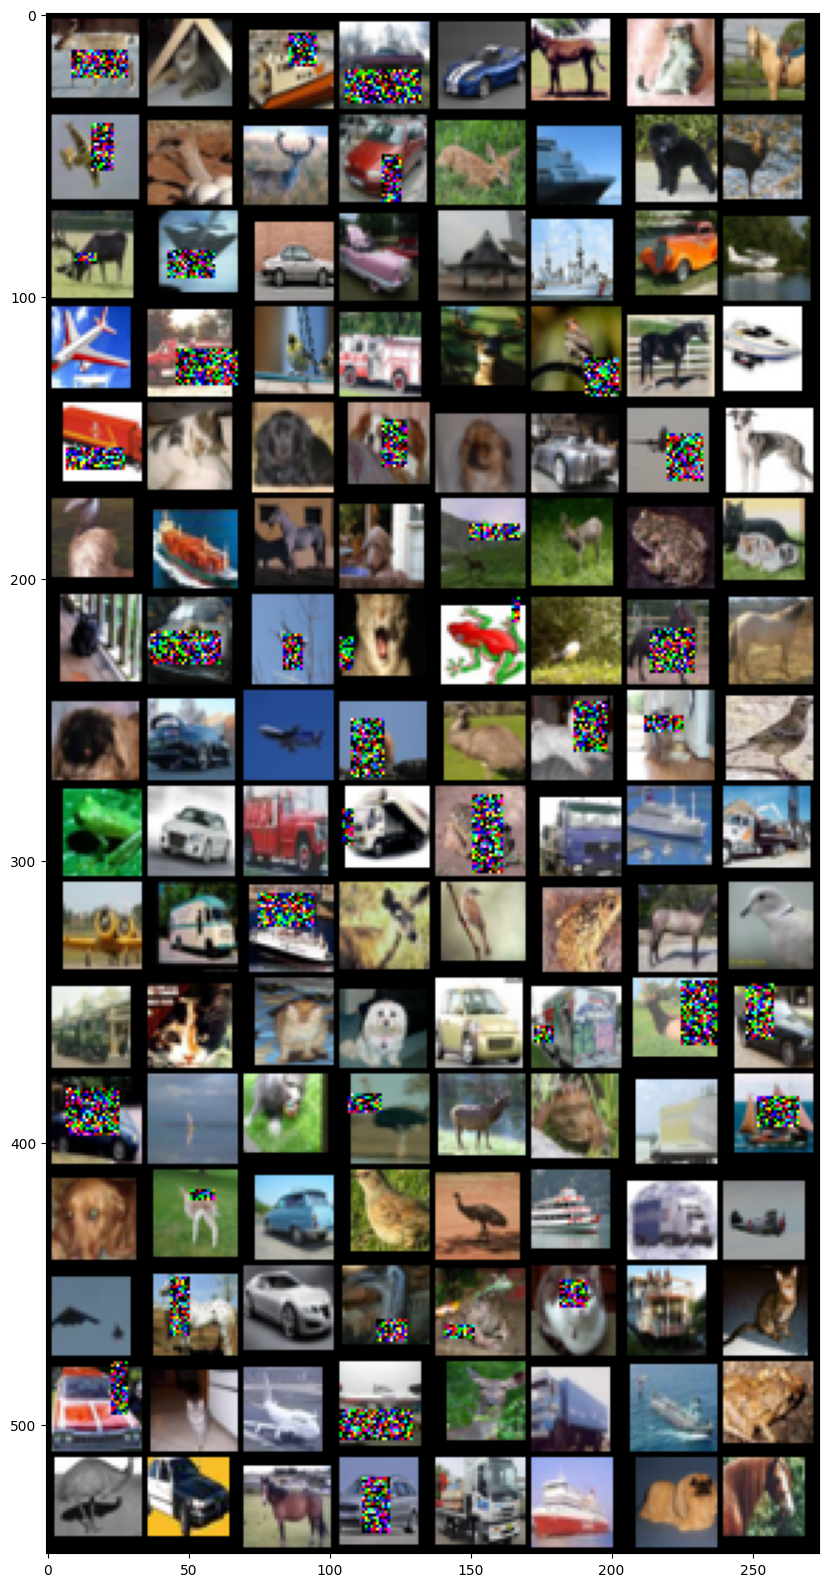

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image
def imshow(img):
    npimg = img.cpu().numpy()
    plt.figure(figsize=(25, 20))  # Adjust the width and height as needed
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
print(f'Dataset type "{DATASET_TYPE}" displaying...\n')

if DATASET_TYPE=='custom':
    dataiter = iter(custom_trainloader)
    images, labels, confidences = next(dataiter)
    # print labels 
    if isinstance(confidences, list):
        # in case we have confidence 
        confidences = confidences[1]
        
    print(' '.join(f'{classes[labels[j]]:5s}: {confidences[j].item():.2f}' for j in range(batch_size)))
elif DATASET_TYPE=='baseline':
#     if training baseline model
    dataiter = iter(baseline_trainloader)
    images, labels = next(dataiter)
    print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))
else:
    raise ValueError(f'Dataset type {DATASET_TYPE} not supported')
    
# show images
imshow(torchvision.utils.make_grid(images))

## Define WideResNet 28_4

In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init
import numpy as np


# Manual implementation of ResNet18
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=num_classes):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Global average pooling layer
        self.linear = nn.Linear(512, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)  # Apply global average pooling
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out



# ResNet18 Architecture
def ResNet18(num_classes=num_classes):
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes=num_classes)

In [8]:
def conv3x3(in_planes, out_planes, stride=1):
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=True)

def conv_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        init.xavier_uniform(m.weight, gain=np.sqrt(2))
        init.constant(m.bias, 0)
    elif classname.find('BatchNorm') != -1:
        init.constant(m.weight, 1)
        init.constant(m.bias, 0)

class WideBasic(nn.Module):
    def __init__(self, in_planes, planes, dropout_rate, stride=1):
        super(WideBasic, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, padding=1, bias=True)
        self.dropout = nn.Dropout(p=dropout_rate)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=True)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=True),
            )

    def forward(self, x):
        out = self.dropout(self.conv1(F.relu(self.bn1(x))))
        out = self.conv2(F.relu(self.bn2(out)))
        out += self.shortcut(x)

        return out

class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion *
                               planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out



class WideResNet(nn.Module):
    def __init__(self, depth, widen_factor, dropout_rate=0.3, num_classes=num_classes, factor=1, block=WideBasic):
        super(WideResNet, self).__init__()
        self.in_planes = 16

        assert ((depth-4)%6 ==0), 'Wide-resnet depth should be 6n+4'
        n = (int)((depth-4)/6)
        k = widen_factor

        nStages = [16, 16*k, 32*k, 64*k]

        self.conv1 = conv3x3(3,nStages[0], stride=1)
        self.layer1 = self._wide_layer(block, nStages[1], n, dropout_rate, stride=factor)
        self.layer2 = self._wide_layer(block, nStages[2], n, dropout_rate, stride=2)
        self.layer3 = self._wide_layer(block, nStages[3], n, dropout_rate, stride=2)
        self.bn1 = nn.BatchNorm2d(nStages[3], momentum=0.9)
        self.linear = nn.Linear(nStages[3], num_classes)

    def _wide_layer(self, block, planes, num_blocks, dropout_rate, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, dropout_rate, stride))
            self.in_planes = planes

        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.relu(self.bn1(out))
        out = F.avg_pool2d(out, 8)
        out = out.view(out.size(0), -1)
        out = self.linear(out)

        return out

def WideResNet_28_4(num_classes, factor=1, block=WideBasic, dropout_rate=0.3):
    return WideResNet(depth=28, widen_factor=4, dropout_rate=dropout_rate, num_classes=num_classes, factor=factor, block=block)

## Model Training

In [9]:
# Initialize the model
net = WideResNet_28_4(num_classes=num_classes)
net.to(device)

WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (layer1): Sequential(
    (0): WideBasic(
      (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (shortcut): Sequential(
        (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      )
    )
    (1): WideBasic(
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (dropout): Dropout(p=0.3, inplace=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, ke

In [10]:
def soft_loss(pred, label, confidence, reweight=False):
    log_prob = F.log_softmax(pred, dim=1)
    n_class = pred.size(1)

    # Make soft one-hot target
    label = label.unsqueeze(1)
    confidence = confidence.unsqueeze(1).float()
    # soft one_hot
    one_hot = torch.ones_like(pred) * (1 - confidence) / (n_class - 1)
    one_hot.scatter_(dim=1, index=label, src=confidence)
    
    # hard one_hot
#     one_hot = torch.zeros_like(pred)
#     one_hot.scatter_(dim=1, index=label, value=1.0)
    # Compute weighted KL loss
    kl = F.kl_div(input=log_prob, target=one_hot, reduction="none").sum(-1)
    kl = kl.unsqueeze(1)  # Unweighted
    if reweight:
        kl = confidence * kl  # Weighted
    return kl.mean()

In [11]:
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import time

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=0.9, weight_decay=1e-4)

# Initialize the scheduler
epochs = EPOCHS
scheduler = CosineAnnealingLR(optimizer, T_max=epochs)  # Cosine Annealing LR Scheduler

# For plotting
train_losses, test_losses, train_accuracies, test_accuracies = [], [], [], []

# Training loop
print(f'\nStart Training...\n')
for epoch in range(epochs):  # loop over the dataset multiple times
    
    start_time = time.time()
    
    running_loss = 0.0
    total_train = 0
    correct_train = 0
    total = 0
    correct = 0
    test_loss = 0.0
    confidences = None
    
    net.train()
    
    if DATASET_TYPE=='baseline':
        trainloader = baseline_trainloader
    elif DATASET_TYPE=='custom':
        trainloader = custom_trainloader
    else:
        raise ValueError('Dataset type is not Valid!')
    
    for i, data in enumerate(trainloader):
            
        if DATASET_TYPE=='baseline':
            inputs, labels = data
        elif DATASET_TYPE=='custom':
            inputs, labels, confidences = data
            # get the inputs
            """when the model returns [augmentation_magnitude, confidence_aa], which is the case
            only when TA with soft labels is applied."""
            if isinstance(confidences, list):
                confidences = confidences[1]
            confidences = confidences.to(device)
        else:
            raise ValueError('Dataset type is not Valid!')
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        inputs, labels = inputs.to(device), labels.to(device)
    
        # Convert labels to one-hot encoded vectors
        # labels_one_hot = F.one_hot(labels, num_classes=10).float()
        
        # forward + backward + optimize
        outputs = net(inputs)
        outputs = outputs.to(device)
        
        if DATASET_TYPE=='custom':
            loss = soft_loss(pred=outputs, label=labels, confidence=confidences, reweight=REWEIGHT)
        else:
            loss = criterion(outputs, labels)
        
        # Check for correct training
        if np.isnan(loss.detach().cpu().numpy()):
            raise ValueError('Loss calculation not correct')
    
        loss.backward()
        optimizer.step()
        
        if tpu:
            xm.mark_step()
        running_loss += loss.item()

        # Calculate training accuracy
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    average_train_loss = running_loss / len(custom_trainloader)
    train_losses.append(average_train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)
    
    with torch.no_grad():
        net.eval()
        for images, labels in baseline_testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # calculate and print average loss for current epoch
    average_test_loss = test_loss / len(custom_testloader)
    test_losses.append(average_test_loss)
    test_accuracy = correct / total
    test_accuracies.append(test_accuracy)
    
    print(f'\nEpoch {epoch + 1} - Train Loss: {average_train_loss:.3f} - Train Accuracy: {100 * train_accuracy: .2f} - Test Loss: {average_test_loss:.3f} - Test Accuracy: {100 * test_accuracy: .2f}')    
    
    scheduler.step()
    end_time = time.time()
    print(f'\nProcessing time: {(end_time - start_time): 3f} seconds.')

print('Finished Training')

# Save the trained model
PATH = f'/kaggle/working/{DATASET_NAME}_net_ta_{DATASET_TYPE}_{epochs}.pth'
torch.save(net.state_dict(), PATH)


Start Training...



/usr/local/lib/python3.10/site-packages/torch/autograd/graph.py:768: UserWarning: aten::kl_div: an autograd kernel was not registered to the Autograd key(s) but we are trying to backprop through it. This may lead to silently incorrect behavior. This behavior is deprecated and will be removed in a future version of PyTorch. If your operator is differentiable, please ensure you have registered an autograd kernel to the correct Autograd key (e.g. DispatchKey::Autograd, DispatchKey::CompositeImplicitAutograd). If your operator is not differentiable, or to squash this warning and use the previous behavior, please register torch::CppFunction::makeFallthrough() to DispatchKey::Autograd. (Triggered internally at ../torch/csrc/autograd/autograd_not_implemented_fallback.cpp:63.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass



Epoch 1 - Train Loss: 1.513 - Train Accuracy:  34.44 - Test Loss: 1.932 - Test Accuracy:  40.54

Processing time:  90.240780 seconds.



Epoch 2 - Train Loss: 1.103 - Train Accuracy:  53.57 - Test Loss: 1.716 - Test Accuracy:  50.70

Processing time:  49.306306 seconds.



Epoch 3 - Train Loss: 0.907 - Train Accuracy:  62.27 - Test Loss: 1.481 - Test Accuracy:  56.58

Processing time:  35.726493 seconds.



Epoch 4 - Train Loss: 0.789 - Train Accuracy:  67.63 - Test Loss: 1.273 - Test Accuracy:  60.67

Processing time:  36.900135 seconds.



Epoch 5 - Train Loss: 0.707 - Train Accuracy:  70.82 - Test Loss: 1.408 - Test Accuracy:  59.85

Processing time:  36.828933 seconds.



Epoch 6 - Train Loss: 0.631 - Train Accuracy:  74.22 - Test Loss: 0.833 - Test Accuracy:  72.38

Processing time:  36.848728 seconds.



Epoch 7 - Train Loss: 0.584 - Train Accuracy:  76.32 - Test Loss: 0.784 - Test Accuracy:  74.95

Processing time:  36.695374 seconds.



Epoch 8 - Train Loss: 0.532 - Train Accuracy:  78.18 - Test Loss: 0.980 - Test Accuracy:  70.93

Processing time:  37.275770 seconds.



Epoch 9 - Train Loss: 0.497 - Train Accuracy:  79.66 - Test Loss: 0.776 - Test Accuracy:  74.91

Processing time:  36.269313 seconds.



Epoch 10 - Train Loss: 0.472 - Train Accuracy:  80.58 - Test Loss: 0.903 - Test Accuracy:  72.50

Processing time:  37.094676 seconds.



Epoch 11 - Train Loss: 0.449 - Train Accuracy:  81.60 - Test Loss: 0.863 - Test Accuracy:  73.38

Processing time:  36.569884 seconds.



Epoch 12 - Train Loss: 0.429 - Train Accuracy:  82.39 - Test Loss: 0.746 - Test Accuracy:  77.73

Processing time:  36.312066 seconds.



Epoch 13 - Train Loss: 0.413 - Train Accuracy:  83.06 - Test Loss: 0.683 - Test Accuracy:  78.86

Processing time:  36.673035 seconds.



Epoch 14 - Train Loss: 0.394 - Train Accuracy:  83.77 - Test Loss: 0.591 - Test Accuracy:  81.67

Processing time:  36.726276 seconds.



Epoch 15 - Train Loss: 0.378 - Train Accuracy:  84.52 - Test Loss: 0.602 - Test Accuracy:  81.81

Processing time:  35.949529 seconds.



Epoch 16 - Train Loss: 0.363 - Train Accuracy:  84.92 - Test Loss: 0.680 - Test Accuracy:  80.10

Processing time:  37.350687 seconds.



Epoch 17 - Train Loss: 0.351 - Train Accuracy:  85.51 - Test Loss: 0.613 - Test Accuracy:  81.35

Processing time:  35.854019 seconds.



Epoch 18 - Train Loss: 0.340 - Train Accuracy:  86.03 - Test Loss: 0.440 - Test Accuracy:  85.95

Processing time:  37.248563 seconds.



Epoch 19 - Train Loss: 0.330 - Train Accuracy:  86.45 - Test Loss: 0.731 - Test Accuracy:  78.62

Processing time:  36.946778 seconds.



Epoch 20 - Train Loss: 0.322 - Train Accuracy:  86.63 - Test Loss: 0.796 - Test Accuracy:  77.78

Processing time:  37.270854 seconds.



Epoch 21 - Train Loss: 0.314 - Train Accuracy:  87.06 - Test Loss: 0.440 - Test Accuracy:  85.26

Processing time:  36.510361 seconds.



Epoch 22 - Train Loss: 0.304 - Train Accuracy:  87.39 - Test Loss: 0.517 - Test Accuracy:  84.12

Processing time:  37.478480 seconds.



Epoch 23 - Train Loss: 0.300 - Train Accuracy:  87.48 - Test Loss: 0.408 - Test Accuracy:  86.77

Processing time:  36.681920 seconds.



Epoch 24 - Train Loss: 0.291 - Train Accuracy:  87.84 - Test Loss: 0.573 - Test Accuracy:  82.58

Processing time:  36.898108 seconds.



Epoch 25 - Train Loss: 0.285 - Train Accuracy:  87.94 - Test Loss: 0.397 - Test Accuracy:  87.54

Processing time:  36.518361 seconds.



Epoch 26 - Train Loss: 0.276 - Train Accuracy:  88.41 - Test Loss: 0.401 - Test Accuracy:  86.72

Processing time:  36.623048 seconds.



Epoch 27 - Train Loss: 0.272 - Train Accuracy:  88.62 - Test Loss: 0.410 - Test Accuracy:  87.14

Processing time:  36.978804 seconds.



Epoch 28 - Train Loss: 0.263 - Train Accuracy:  88.99 - Test Loss: 0.383 - Test Accuracy:  87.81

Processing time:  36.155593 seconds.



Epoch 29 - Train Loss: 0.263 - Train Accuracy:  88.89 - Test Loss: 0.375 - Test Accuracy:  88.48

Processing time:  37.851376 seconds.



Epoch 30 - Train Loss: 0.259 - Train Accuracy:  89.13 - Test Loss: 0.433 - Test Accuracy:  86.99

Processing time:  36.405704 seconds.



Epoch 31 - Train Loss: 0.250 - Train Accuracy:  89.28 - Test Loss: 0.433 - Test Accuracy:  86.63

Processing time:  36.590103 seconds.



Epoch 32 - Train Loss: 0.248 - Train Accuracy:  89.54 - Test Loss: 0.348 - Test Accuracy:  89.06

Processing time:  37.383717 seconds.



Epoch 33 - Train Loss: 0.241 - Train Accuracy:  89.82 - Test Loss: 0.479 - Test Accuracy:  87.05

Processing time:  37.265996 seconds.



Epoch 34 - Train Loss: 0.239 - Train Accuracy:  90.09 - Test Loss: 0.347 - Test Accuracy:  89.28

Processing time:  36.033150 seconds.



Epoch 35 - Train Loss: 0.236 - Train Accuracy:  90.06 - Test Loss: 0.449 - Test Accuracy:  86.76

Processing time:  36.890012 seconds.



Epoch 36 - Train Loss: 0.228 - Train Accuracy:  90.45 - Test Loss: 0.415 - Test Accuracy:  88.12

Processing time:  36.528029 seconds.



Epoch 37 - Train Loss: 0.226 - Train Accuracy:  90.30 - Test Loss: 0.414 - Test Accuracy:  87.77

Processing time:  36.234958 seconds.



Epoch 38 - Train Loss: 0.223 - Train Accuracy:  90.45 - Test Loss: 0.475 - Test Accuracy:  86.49

Processing time:  35.745157 seconds.



Epoch 39 - Train Loss: 0.225 - Train Accuracy:  90.37 - Test Loss: 0.376 - Test Accuracy:  88.86

Processing time:  37.277109 seconds.



Epoch 40 - Train Loss: 0.219 - Train Accuracy:  90.67 - Test Loss: 0.355 - Test Accuracy:  89.24

Processing time:  35.999484 seconds.



Epoch 41 - Train Loss: 0.219 - Train Accuracy:  90.70 - Test Loss: 0.315 - Test Accuracy:  90.41

Processing time:  37.256567 seconds.



Epoch 42 - Train Loss: 0.213 - Train Accuracy:  91.00 - Test Loss: 0.405 - Test Accuracy:  88.37

Processing time:  37.381583 seconds.



Epoch 43 - Train Loss: 0.214 - Train Accuracy:  90.77 - Test Loss: 0.446 - Test Accuracy:  87.24

Processing time:  36.361915 seconds.



Epoch 44 - Train Loss: 0.207 - Train Accuracy:  91.30 - Test Loss: 0.428 - Test Accuracy:  87.14

Processing time:  35.572842 seconds.



Epoch 45 - Train Loss: 0.206 - Train Accuracy:  91.08 - Test Loss: 0.333 - Test Accuracy:  89.85

Processing time:  35.671807 seconds.



Epoch 46 - Train Loss: 0.201 - Train Accuracy:  91.24 - Test Loss: 0.415 - Test Accuracy:  87.75

Processing time:  38.089148 seconds.



Epoch 47 - Train Loss: 0.197 - Train Accuracy:  91.56 - Test Loss: 0.382 - Test Accuracy:  88.99

Processing time:  37.313870 seconds.



Epoch 48 - Train Loss: 0.199 - Train Accuracy:  91.46 - Test Loss: 0.375 - Test Accuracy:  88.66

Processing time:  37.415540 seconds.



Epoch 49 - Train Loss: 0.198 - Train Accuracy:  91.55 - Test Loss: 0.359 - Test Accuracy:  89.84

Processing time:  36.609635 seconds.



Epoch 50 - Train Loss: 0.193 - Train Accuracy:  91.64 - Test Loss: 0.398 - Test Accuracy:  88.68

Processing time:  37.855724 seconds.



Epoch 51 - Train Loss: 0.191 - Train Accuracy:  91.71 - Test Loss: 0.296 - Test Accuracy:  90.92

Processing time:  37.157251 seconds.



Epoch 52 - Train Loss: 0.189 - Train Accuracy:  91.78 - Test Loss: 0.405 - Test Accuracy:  88.53

Processing time:  36.963174 seconds.



Epoch 53 - Train Loss: 0.185 - Train Accuracy:  92.05 - Test Loss: 0.442 - Test Accuracy:  88.07

Processing time:  36.884938 seconds.



Epoch 54 - Train Loss: 0.183 - Train Accuracy:  92.05 - Test Loss: 0.385 - Test Accuracy:  89.09

Processing time:  36.414208 seconds.



Epoch 55 - Train Loss: 0.183 - Train Accuracy:  92.03 - Test Loss: 0.367 - Test Accuracy:  89.49

Processing time:  35.594571 seconds.



Epoch 56 - Train Loss: 0.176 - Train Accuracy:  92.21 - Test Loss: 0.492 - Test Accuracy:  86.61

Processing time:  36.989008 seconds.



Epoch 57 - Train Loss: 0.177 - Train Accuracy:  92.25 - Test Loss: 0.398 - Test Accuracy:  88.81

Processing time:  35.919726 seconds.



Epoch 58 - Train Loss: 0.174 - Train Accuracy:  92.47 - Test Loss: 0.399 - Test Accuracy:  89.44

Processing time:  37.229478 seconds.



Epoch 59 - Train Loss: 0.174 - Train Accuracy:  92.39 - Test Loss: 0.326 - Test Accuracy:  90.16

Processing time:  35.970585 seconds.



Epoch 60 - Train Loss: 0.171 - Train Accuracy:  92.43 - Test Loss: 0.569 - Test Accuracy:  86.06

Processing time:  35.805519 seconds.



Epoch 61 - Train Loss: 0.168 - Train Accuracy:  92.75 - Test Loss: 0.441 - Test Accuracy:  88.41

Processing time:  35.703606 seconds.



Epoch 62 - Train Loss: 0.166 - Train Accuracy:  92.79 - Test Loss: 0.466 - Test Accuracy:  87.20

Processing time:  35.842076 seconds.



Epoch 63 - Train Loss: 0.168 - Train Accuracy:  92.65 - Test Loss: 0.406 - Test Accuracy:  88.69

Processing time:  36.551206 seconds.



Epoch 64 - Train Loss: 0.162 - Train Accuracy:  92.76 - Test Loss: 0.384 - Test Accuracy:  89.81

Processing time:  35.450778 seconds.



Epoch 65 - Train Loss: 0.161 - Train Accuracy:  92.80 - Test Loss: 0.371 - Test Accuracy:  89.63

Processing time:  35.728760 seconds.



Epoch 66 - Train Loss: 0.160 - Train Accuracy:  92.95 - Test Loss: 0.390 - Test Accuracy:  89.17

Processing time:  35.751699 seconds.



Epoch 67 - Train Loss: 0.161 - Train Accuracy:  92.92 - Test Loss: 0.329 - Test Accuracy:  90.98

Processing time:  35.905588 seconds.



Epoch 68 - Train Loss: 0.155 - Train Accuracy:  93.20 - Test Loss: 0.327 - Test Accuracy:  91.18

Processing time:  36.063676 seconds.



Epoch 69 - Train Loss: 0.148 - Train Accuracy:  93.44 - Test Loss: 0.406 - Test Accuracy:  88.87

Processing time:  37.909308 seconds.



Epoch 70 - Train Loss: 0.152 - Train Accuracy:  93.31 - Test Loss: 0.297 - Test Accuracy:  91.70

Processing time:  36.815487 seconds.



Epoch 71 - Train Loss: 0.151 - Train Accuracy:  93.37 - Test Loss: 0.291 - Test Accuracy:  91.74

Processing time:  37.107045 seconds.



Epoch 72 - Train Loss: 0.146 - Train Accuracy:  93.45 - Test Loss: 0.353 - Test Accuracy:  90.52

Processing time:  36.865951 seconds.



Epoch 73 - Train Loss: 0.152 - Train Accuracy:  93.04 - Test Loss: 0.332 - Test Accuracy:  90.82

Processing time:  36.418375 seconds.



Epoch 74 - Train Loss: 0.147 - Train Accuracy:  93.44 - Test Loss: 0.342 - Test Accuracy:  90.66

Processing time:  36.319006 seconds.



Epoch 75 - Train Loss: 0.141 - Train Accuracy:  93.70 - Test Loss: 0.583 - Test Accuracy:  86.36

Processing time:  36.461604 seconds.



Epoch 76 - Train Loss: 0.140 - Train Accuracy:  93.74 - Test Loss: 0.368 - Test Accuracy:  90.27

Processing time:  36.316427 seconds.



Epoch 77 - Train Loss: 0.143 - Train Accuracy:  93.53 - Test Loss: 0.355 - Test Accuracy:  90.69

Processing time:  36.489571 seconds.



Epoch 78 - Train Loss: 0.138 - Train Accuracy:  93.84 - Test Loss: 0.417 - Test Accuracy:  89.57

Processing time:  36.441332 seconds.



Epoch 79 - Train Loss: 0.136 - Train Accuracy:  93.80 - Test Loss: 0.388 - Test Accuracy:  89.90

Processing time:  36.221675 seconds.



Epoch 80 - Train Loss: 0.134 - Train Accuracy:  94.05 - Test Loss: 0.509 - Test Accuracy:  87.01

Processing time:  36.022348 seconds.



Epoch 81 - Train Loss: 0.133 - Train Accuracy:  94.01 - Test Loss: 0.304 - Test Accuracy:  91.97

Processing time:  35.675276 seconds.



Epoch 82 - Train Loss: 0.130 - Train Accuracy:  94.17 - Test Loss: 0.478 - Test Accuracy:  88.15

Processing time:  36.465127 seconds.



Epoch 83 - Train Loss: 0.132 - Train Accuracy:  94.12 - Test Loss: 0.374 - Test Accuracy:  90.21

Processing time:  36.663172 seconds.



Epoch 84 - Train Loss: 0.126 - Train Accuracy:  94.19 - Test Loss: 0.400 - Test Accuracy:  90.27

Processing time:  36.239540 seconds.



Epoch 85 - Train Loss: 0.129 - Train Accuracy:  94.10 - Test Loss: 0.343 - Test Accuracy:  90.70

Processing time:  36.587582 seconds.



Epoch 86 - Train Loss: 0.122 - Train Accuracy:  94.39 - Test Loss: 0.367 - Test Accuracy:  90.60

Processing time:  36.181026 seconds.



Epoch 87 - Train Loss: 0.122 - Train Accuracy:  94.48 - Test Loss: 0.354 - Test Accuracy:  90.77

Processing time:  36.527938 seconds.



Epoch 88 - Train Loss: 0.120 - Train Accuracy:  94.48 - Test Loss: 0.302 - Test Accuracy:  92.20

Processing time:  37.295398 seconds.



Epoch 89 - Train Loss: 0.121 - Train Accuracy:  94.51 - Test Loss: 0.380 - Test Accuracy:  90.49

Processing time:  36.657743 seconds.



Epoch 90 - Train Loss: 0.118 - Train Accuracy:  94.58 - Test Loss: 0.394 - Test Accuracy:  90.46

Processing time:  36.867550 seconds.



Epoch 91 - Train Loss: 0.112 - Train Accuracy:  94.90 - Test Loss: 0.326 - Test Accuracy:  91.75

Processing time:  36.668739 seconds.



Epoch 92 - Train Loss: 0.115 - Train Accuracy:  94.73 - Test Loss: 0.274 - Test Accuracy:  92.49

Processing time:  36.636152 seconds.



Epoch 93 - Train Loss: 0.111 - Train Accuracy:  94.83 - Test Loss: 0.348 - Test Accuracy:  91.32

Processing time:  36.564045 seconds.



Epoch 94 - Train Loss: 0.113 - Train Accuracy:  94.75 - Test Loss: 0.343 - Test Accuracy:  90.71

Processing time:  37.325596 seconds.



Epoch 95 - Train Loss: 0.111 - Train Accuracy:  94.97 - Test Loss: 0.345 - Test Accuracy:  91.06

Processing time:  36.613185 seconds.



Epoch 96 - Train Loss: 0.110 - Train Accuracy:  94.94 - Test Loss: 0.365 - Test Accuracy:  90.68

Processing time:  36.766450 seconds.



Epoch 97 - Train Loss: 0.107 - Train Accuracy:  95.09 - Test Loss: 0.262 - Test Accuracy:  93.24

Processing time:  36.538310 seconds.



Epoch 98 - Train Loss: 0.107 - Train Accuracy:  95.08 - Test Loss: 0.269 - Test Accuracy:  92.65

Processing time:  37.125707 seconds.



Epoch 99 - Train Loss: 0.104 - Train Accuracy:  95.21 - Test Loss: 0.275 - Test Accuracy:  92.78

Processing time:  36.961119 seconds.



Epoch 100 - Train Loss: 0.100 - Train Accuracy:  95.34 - Test Loss: 0.305 - Test Accuracy:  92.03

Processing time:  36.932666 seconds.



Epoch 101 - Train Loss: 0.101 - Train Accuracy:  95.28 - Test Loss: 0.290 - Test Accuracy:  92.36

Processing time:  36.713062 seconds.



Epoch 102 - Train Loss: 0.095 - Train Accuracy:  95.57 - Test Loss: 0.291 - Test Accuracy:  92.82

Processing time:  36.651017 seconds.



Epoch 103 - Train Loss: 0.099 - Train Accuracy:  95.42 - Test Loss: 0.351 - Test Accuracy:  91.75

Processing time:  35.916642 seconds.



Epoch 104 - Train Loss: 0.093 - Train Accuracy:  95.63 - Test Loss: 0.349 - Test Accuracy:  91.88

Processing time:  35.569775 seconds.



Epoch 105 - Train Loss: 0.093 - Train Accuracy:  95.58 - Test Loss: 0.345 - Test Accuracy:  92.07

Processing time:  36.554182 seconds.



Epoch 106 - Train Loss: 0.092 - Train Accuracy:  95.68 - Test Loss: 0.291 - Test Accuracy:  93.07

Processing time:  35.878476 seconds.



Epoch 107 - Train Loss: 0.090 - Train Accuracy:  95.78 - Test Loss: 0.306 - Test Accuracy:  92.47

Processing time:  35.607974 seconds.



Epoch 108 - Train Loss: 0.095 - Train Accuracy:  95.61 - Test Loss: 0.262 - Test Accuracy:  93.32

Processing time:  36.277310 seconds.



Epoch 109 - Train Loss: 0.087 - Train Accuracy:  95.80 - Test Loss: 0.348 - Test Accuracy:  91.06

Processing time:  35.847690 seconds.



Epoch 110 - Train Loss: 0.085 - Train Accuracy:  95.98 - Test Loss: 0.264 - Test Accuracy:  93.14

Processing time:  35.585734 seconds.



Epoch 111 - Train Loss: 0.082 - Train Accuracy:  96.04 - Test Loss: 0.258 - Test Accuracy:  93.74

Processing time:  35.538231 seconds.



Epoch 112 - Train Loss: 0.086 - Train Accuracy:  95.85 - Test Loss: 0.284 - Test Accuracy:  92.96

Processing time:  35.616971 seconds.



Epoch 113 - Train Loss: 0.081 - Train Accuracy:  96.14 - Test Loss: 0.337 - Test Accuracy:  91.67

Processing time:  35.495138 seconds.



Epoch 114 - Train Loss: 0.078 - Train Accuracy:  96.23 - Test Loss: 0.331 - Test Accuracy:  92.62

Processing time:  37.284477 seconds.



Epoch 115 - Train Loss: 0.079 - Train Accuracy:  96.12 - Test Loss: 0.284 - Test Accuracy:  93.03

Processing time:  36.170309 seconds.



Epoch 116 - Train Loss: 0.079 - Train Accuracy:  96.25 - Test Loss: 0.280 - Test Accuracy:  93.08

Processing time:  35.731418 seconds.



Epoch 117 - Train Loss: 0.076 - Train Accuracy:  96.37 - Test Loss: 0.489 - Test Accuracy:  89.92

Processing time:  37.330954 seconds.



Epoch 118 - Train Loss: 0.077 - Train Accuracy:  96.26 - Test Loss: 0.322 - Test Accuracy:  92.38

Processing time:  37.124051 seconds.



Epoch 119 - Train Loss: 0.069 - Train Accuracy:  96.58 - Test Loss: 0.287 - Test Accuracy:  93.36

Processing time:  36.524547 seconds.



Epoch 120 - Train Loss: 0.072 - Train Accuracy:  96.49 - Test Loss: 0.301 - Test Accuracy:  92.86

Processing time:  36.754620 seconds.



Epoch 121 - Train Loss: 0.068 - Train Accuracy:  96.74 - Test Loss: 0.320 - Test Accuracy:  92.67

Processing time:  36.577472 seconds.



Epoch 122 - Train Loss: 0.071 - Train Accuracy:  96.54 - Test Loss: 0.308 - Test Accuracy:  92.30

Processing time:  37.345168 seconds.



Epoch 123 - Train Loss: 0.065 - Train Accuracy:  96.81 - Test Loss: 0.328 - Test Accuracy:  92.35

Processing time:  36.838500 seconds.



Epoch 124 - Train Loss: 0.064 - Train Accuracy:  96.80 - Test Loss: 0.358 - Test Accuracy:  92.38

Processing time:  36.691145 seconds.



Epoch 125 - Train Loss: 0.064 - Train Accuracy:  96.83 - Test Loss: 0.347 - Test Accuracy:  92.38

Processing time:  36.378230 seconds.



Epoch 126 - Train Loss: 0.061 - Train Accuracy:  96.97 - Test Loss: 0.289 - Test Accuracy:  93.58

Processing time:  36.371715 seconds.



Epoch 127 - Train Loss: 0.054 - Train Accuracy:  97.35 - Test Loss: 0.287 - Test Accuracy:  93.39

Processing time:  36.331356 seconds.



Epoch 128 - Train Loss: 0.057 - Train Accuracy:  97.22 - Test Loss: 0.277 - Test Accuracy:  93.86

Processing time:  36.795701 seconds.



Epoch 129 - Train Loss: 0.055 - Train Accuracy:  97.23 - Test Loss: 0.270 - Test Accuracy:  93.94

Processing time:  36.960211 seconds.



Epoch 130 - Train Loss: 0.058 - Train Accuracy:  97.17 - Test Loss: 0.249 - Test Accuracy:  94.14

Processing time:  36.277822 seconds.



Epoch 131 - Train Loss: 0.054 - Train Accuracy:  97.33 - Test Loss: 0.239 - Test Accuracy:  94.17

Processing time:  36.680668 seconds.



Epoch 132 - Train Loss: 0.053 - Train Accuracy:  97.35 - Test Loss: 0.263 - Test Accuracy:  93.98

Processing time:  36.668602 seconds.



Epoch 133 - Train Loss: 0.050 - Train Accuracy:  97.53 - Test Loss: 0.263 - Test Accuracy:  93.84

Processing time:  36.713851 seconds.



Epoch 134 - Train Loss: 0.050 - Train Accuracy:  97.45 - Test Loss: 0.262 - Test Accuracy:  93.90

Processing time:  37.047801 seconds.



Epoch 135 - Train Loss: 0.050 - Train Accuracy:  97.38 - Test Loss: 0.294 - Test Accuracy:  93.53

Processing time:  37.133513 seconds.



Epoch 136 - Train Loss: 0.049 - Train Accuracy:  97.45 - Test Loss: 0.260 - Test Accuracy:  94.14

Processing time:  36.950556 seconds.



Epoch 137 - Train Loss: 0.047 - Train Accuracy:  97.55 - Test Loss: 0.281 - Test Accuracy:  93.83

Processing time:  36.795912 seconds.



Epoch 138 - Train Loss: 0.046 - Train Accuracy:  97.64 - Test Loss: 0.284 - Test Accuracy:  93.81

Processing time:  37.534576 seconds.



Epoch 139 - Train Loss: 0.043 - Train Accuracy:  97.82 - Test Loss: 0.283 - Test Accuracy:  94.10

Processing time:  36.551702 seconds.



Epoch 140 - Train Loss: 0.043 - Train Accuracy:  97.79 - Test Loss: 0.255 - Test Accuracy:  94.31

Processing time:  35.927243 seconds.



Epoch 141 - Train Loss: 0.043 - Train Accuracy:  97.81 - Test Loss: 0.268 - Test Accuracy:  94.13

Processing time:  36.761262 seconds.



Epoch 142 - Train Loss: 0.041 - Train Accuracy:  97.77 - Test Loss: 0.252 - Test Accuracy:  94.49

Processing time:  36.637759 seconds.



Epoch 143 - Train Loss: 0.040 - Train Accuracy:  97.89 - Test Loss: 0.252 - Test Accuracy:  94.33

Processing time:  36.583485 seconds.



Epoch 144 - Train Loss: 0.036 - Train Accuracy:  98.04 - Test Loss: 0.245 - Test Accuracy:  94.91

Processing time:  36.761042 seconds.



Epoch 145 - Train Loss: 0.038 - Train Accuracy:  98.01 - Test Loss: 0.247 - Test Accuracy:  94.73

Processing time:  36.654322 seconds.



Epoch 146 - Train Loss: 0.035 - Train Accuracy:  98.10 - Test Loss: 0.255 - Test Accuracy:  94.63

Processing time:  37.094127 seconds.



Epoch 147 - Train Loss: 0.032 - Train Accuracy:  98.28 - Test Loss: 0.227 - Test Accuracy:  94.89

Processing time:  37.279296 seconds.



Epoch 148 - Train Loss: 0.033 - Train Accuracy:  98.19 - Test Loss: 0.234 - Test Accuracy:  94.84

Processing time:  36.959281 seconds.



Epoch 149 - Train Loss: 0.033 - Train Accuracy:  98.22 - Test Loss: 0.238 - Test Accuracy:  94.70

Processing time:  35.728965 seconds.



Epoch 150 - Train Loss: 0.031 - Train Accuracy:  98.24 - Test Loss: 0.225 - Test Accuracy:  95.05

Processing time:  35.934529 seconds.



Epoch 151 - Train Loss: 0.031 - Train Accuracy:  98.34 - Test Loss: 0.240 - Test Accuracy:  95.13

Processing time:  35.673143 seconds.



Epoch 152 - Train Loss: 0.029 - Train Accuracy:  98.42 - Test Loss: 0.252 - Test Accuracy:  94.83

Processing time:  35.788688 seconds.



Epoch 153 - Train Loss: 0.028 - Train Accuracy:  98.53 - Test Loss: 0.232 - Test Accuracy:  95.23

Processing time:  35.483567 seconds.



Epoch 154 - Train Loss: 0.029 - Train Accuracy:  98.39 - Test Loss: 0.224 - Test Accuracy:  94.89

Processing time:  37.769604 seconds.



Epoch 155 - Train Loss: 0.028 - Train Accuracy:  98.38 - Test Loss: 0.234 - Test Accuracy:  95.14

Processing time:  37.199515 seconds.



Epoch 156 - Train Loss: 0.027 - Train Accuracy:  98.54 - Test Loss: 0.244 - Test Accuracy:  95.12

Processing time:  36.816852 seconds.



Epoch 157 - Train Loss: 0.026 - Train Accuracy:  98.56 - Test Loss: 0.221 - Test Accuracy:  95.06

Processing time:  35.623350 seconds.



Epoch 158 - Train Loss: 0.027 - Train Accuracy:  98.59 - Test Loss: 0.232 - Test Accuracy:  95.29

Processing time:  36.242554 seconds.



Epoch 159 - Train Loss: 0.026 - Train Accuracy:  98.59 - Test Loss: 0.227 - Test Accuracy:  95.27

Processing time:  36.022725 seconds.



Epoch 160 - Train Loss: 0.026 - Train Accuracy:  98.57 - Test Loss: 0.224 - Test Accuracy:  95.28

Processing time:  35.802934 seconds.



Epoch 161 - Train Loss: 0.025 - Train Accuracy:  98.55 - Test Loss: 0.221 - Test Accuracy:  95.40

Processing time:  36.991889 seconds.



Epoch 162 - Train Loss: 0.025 - Train Accuracy:  98.62 - Test Loss: 0.205 - Test Accuracy:  95.50

Processing time:  36.643474 seconds.



Epoch 163 - Train Loss: 0.024 - Train Accuracy:  98.69 - Test Loss: 0.217 - Test Accuracy:  95.42

Processing time:  37.158154 seconds.



Epoch 164 - Train Loss: 0.023 - Train Accuracy:  98.72 - Test Loss: 0.217 - Test Accuracy:  95.37

Processing time:  35.838048 seconds.



Epoch 165 - Train Loss: 0.022 - Train Accuracy:  98.75 - Test Loss: 0.214 - Test Accuracy:  95.36

Processing time:  35.927512 seconds.



Epoch 166 - Train Loss: 0.023 - Train Accuracy:  98.73 - Test Loss: 0.206 - Test Accuracy:  95.31

Processing time:  35.811960 seconds.



Epoch 167 - Train Loss: 0.022 - Train Accuracy:  98.78 - Test Loss: 0.209 - Test Accuracy:  95.53

Processing time:  35.717688 seconds.



Epoch 168 - Train Loss: 0.022 - Train Accuracy:  98.75 - Test Loss: 0.220 - Test Accuracy:  95.42

Processing time:  35.595885 seconds.



Epoch 169 - Train Loss: 0.022 - Train Accuracy:  98.77 - Test Loss: 0.209 - Test Accuracy:  95.60

Processing time:  35.644800 seconds.



Epoch 170 - Train Loss: 0.022 - Train Accuracy:  98.76 - Test Loss: 0.218 - Test Accuracy:  95.45

Processing time:  35.419479 seconds.



Epoch 171 - Train Loss: 0.022 - Train Accuracy:  98.75 - Test Loss: 0.207 - Test Accuracy:  95.65

Processing time:  35.781440 seconds.



Epoch 172 - Train Loss: 0.021 - Train Accuracy:  98.86 - Test Loss: 0.200 - Test Accuracy:  95.56

Processing time:  36.873677 seconds.



Epoch 173 - Train Loss: 0.021 - Train Accuracy:  98.74 - Test Loss: 0.203 - Test Accuracy:  95.75

Processing time:  38.039531 seconds.



Epoch 174 - Train Loss: 0.021 - Train Accuracy:  98.85 - Test Loss: 0.201 - Test Accuracy:  95.62

Processing time:  36.817320 seconds.



Epoch 175 - Train Loss: 0.019 - Train Accuracy:  98.91 - Test Loss: 0.202 - Test Accuracy:  95.62

Processing time:  36.175318 seconds.



Epoch 176 - Train Loss: 0.019 - Train Accuracy:  98.95 - Test Loss: 0.205 - Test Accuracy:  95.59

Processing time:  36.869982 seconds.



Epoch 177 - Train Loss: 0.020 - Train Accuracy:  98.84 - Test Loss: 0.197 - Test Accuracy:  95.72

Processing time:  37.358331 seconds.



Epoch 178 - Train Loss: 0.020 - Train Accuracy:  98.85 - Test Loss: 0.200 - Test Accuracy:  95.70

Processing time:  37.001985 seconds.



Epoch 179 - Train Loss: 0.019 - Train Accuracy:  98.96 - Test Loss: 0.199 - Test Accuracy:  95.63

Processing time:  36.785420 seconds.



Epoch 180 - Train Loss: 0.019 - Train Accuracy:  98.95 - Test Loss: 0.202 - Test Accuracy:  95.55

Processing time:  35.917158 seconds.



Epoch 181 - Train Loss: 0.019 - Train Accuracy:  98.88 - Test Loss: 0.193 - Test Accuracy:  95.76

Processing time:  36.974643 seconds.



Epoch 182 - Train Loss: 0.019 - Train Accuracy:  98.90 - Test Loss: 0.205 - Test Accuracy:  95.59

Processing time:  37.122088 seconds.



Epoch 183 - Train Loss: 0.019 - Train Accuracy:  98.88 - Test Loss: 0.198 - Test Accuracy:  95.66

Processing time:  36.606673 seconds.



Epoch 184 - Train Loss: 0.018 - Train Accuracy:  98.94 - Test Loss: 0.196 - Test Accuracy:  95.64

Processing time:  36.503891 seconds.



Epoch 185 - Train Loss: 0.018 - Train Accuracy:  98.95 - Test Loss: 0.193 - Test Accuracy:  95.79

Processing time:  36.957630 seconds.



Epoch 186 - Train Loss: 0.019 - Train Accuracy:  98.92 - Test Loss: 0.194 - Test Accuracy:  95.83

Processing time:  37.067924 seconds.



Epoch 187 - Train Loss: 0.018 - Train Accuracy:  98.98 - Test Loss: 0.199 - Test Accuracy:  95.71

Processing time:  37.582452 seconds.



Epoch 188 - Train Loss: 0.018 - Train Accuracy:  98.98 - Test Loss: 0.200 - Test Accuracy:  95.75

Processing time:  37.183810 seconds.



Epoch 189 - Train Loss: 0.018 - Train Accuracy:  98.97 - Test Loss: 0.195 - Test Accuracy:  95.80

Processing time:  36.615504 seconds.



Epoch 190 - Train Loss: 0.018 - Train Accuracy:  99.03 - Test Loss: 0.198 - Test Accuracy:  95.71

Processing time:  36.552284 seconds.



Epoch 191 - Train Loss: 0.018 - Train Accuracy:  98.96 - Test Loss: 0.203 - Test Accuracy:  95.63

Processing time:  37.356132 seconds.



Epoch 192 - Train Loss: 0.018 - Train Accuracy:  98.97 - Test Loss: 0.195 - Test Accuracy:  95.65

Processing time:  36.763128 seconds.



Epoch 193 - Train Loss: 0.019 - Train Accuracy:  98.96 - Test Loss: 0.193 - Test Accuracy:  95.67

Processing time:  37.612494 seconds.



Epoch 194 - Train Loss: 0.018 - Train Accuracy:  98.95 - Test Loss: 0.195 - Test Accuracy:  95.78

Processing time:  37.860968 seconds.



Epoch 195 - Train Loss: 0.018 - Train Accuracy:  98.96 - Test Loss: 0.197 - Test Accuracy:  95.78

Processing time:  36.905020 seconds.



Epoch 196 - Train Loss: 0.017 - Train Accuracy:  99.06 - Test Loss: 0.201 - Test Accuracy:  95.76

Processing time:  36.905657 seconds.



Epoch 197 - Train Loss: 0.018 - Train Accuracy:  98.95 - Test Loss: 0.201 - Test Accuracy:  95.70

Processing time:  36.807012 seconds.



Epoch 198 - Train Loss: 0.018 - Train Accuracy:  99.01 - Test Loss: 0.199 - Test Accuracy:  95.62

Processing time:  36.771391 seconds.



Epoch 199 - Train Loss: 0.018 - Train Accuracy:  98.98 - Test Loss: 0.195 - Test Accuracy:  95.82

Processing time:  37.006432 seconds.



Epoch 200 - Train Loss: 0.018 - Train Accuracy:  98.96 - Test Loss: 0.203 - Test Accuracy:  95.55

Processing time:  38.161870 seconds.
Finished Training


In [12]:
import csv

csv_path = f'/kaggle/working/{DATASET_NAME}_training_metrics.csv'
with open(csv_path, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Loss', 'Train Accuracy', 'Test Loss', 'Test Accuracy'])
    for epoch in range(epochs):
        writer.writerow([epoch + 1, train_losses[epoch], train_accuracies[epoch], test_losses[epoch], test_accuracies[epoch]])

print(f'\nMetrics saved to {csv_path}')


Metrics saved to /kaggle/working/CIFAR10_training_metrics.csv


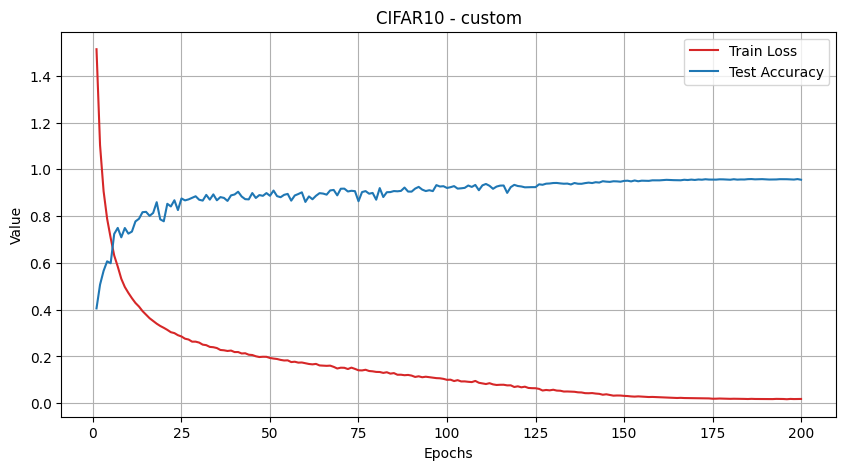

In [13]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_losses, label='Train Loss', color='tab:red')
plt.plot(range(1, epochs + 1), test_accuracies, label='Test Accuracy', color='tab:blue')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.title(f'{DATASET_NAME} - {DATASET_TYPE}')
plt.legend()
plt.grid(True)
plt.show()

## Evaluate the model on Testset

In [14]:
import torch
import numpy as np

# Evaluate the CIFAR-10 dataset
correct = 0
total = 0

with torch.no_grad():
    net.eval()
    for images, labels in baseline_testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    if total == 0:
        print('No images found for CIFAR-10 dataset.')
    else:
        cifar10_accuracy = 100 * correct / total
        print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')

if not tpu:
    # Clear GPU memory
    torch.cuda.empty_cache()

    # Clear CPU memory
    torch.cuda.ipc_collect()

# Define the list of corruptions
corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
               'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
               'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
               'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# Define the batch size
batch_size = 256 

# Create an empty dictionary to store corrupted datasets
corrupted_datasets = {}

# Prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# List to store average accuracies for each corruption dataset
average_accuracies = []

# Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
for corruption in corruptions:
    print(f"Testing on corruption: {corruption}")

    # Load and test datasets for all 5 severity levels of the current corruption
    try:
        if DATASET_NAME=='CIFAR10':
            np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
        elif DATASET_NAME=='CIFAR100':
            np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
        else:
            raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
            
        np_data_c_splits = np.array_split(np_data_c, 5)
        
        # List to store accuracies of all severity levels for averaging
        accuracies = []

        for i, np_data_c_split in enumerate(np_data_c_splits):
            custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
            custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

            # Testing loop for the current corruption dataset split
            correct = 0
            total = 0

            with torch.no_grad():
                images_loaded = 0  # Counter for images loaded for the current corruption
                for images, labels in custom_dataloader:
                    images_loaded += len(images)  # Increment the counter by the number of images loaded
                    images, labels = images.to(device), labels.to(device)
                    # Calculate outputs by running images through the network
                    outputs = net(images)
                    # The class with the highest energy is chosen as prediction
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()

                if total == 0:
                    print(f'No images found for {corruption} dataset split {i+1}.')
                else:
                    accuracy = 100 * correct / total
                    print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
                    accuracies.append(accuracy)

                # Print the number of images loaded for the current corruption dataset split
                #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
                if not tpu:
                    # Clear GPU memory
                    torch.cuda.empty_cache()
                    # Clear CPU memory
                    torch.cuda.ipc_collect()

                # Delete variables to free up memory
                del custom_dataset
                del custom_dataloader

        # Calculate and print the average accuracy for the corruption dataset
        if accuracies:
            average_accuracy = sum(accuracies) / len(accuracies)
            average_accuracies.append(average_accuracy)
            print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

    except FileNotFoundError:
        print(f'Corruption {corruption} dataset not found.')
        continue

# Calculate and print the average robust accuracy
if average_accuracies:
    average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
    print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
else:
    print("No corrupt datasets found for evaluation.")

Accuracy of the network on the CIFAR-10 test dataset: 95.55 %
Testing on corruption: gaussian_noise


Accuracy of the network on gaussian_noise dataset split 1: 79.62 %


Accuracy of the network on gaussian_noise dataset split 2: 57.24 %


Accuracy of the network on gaussian_noise dataset split 3: 36.82 %


Accuracy of the network on gaussian_noise dataset split 4: 30.90 %


Accuracy of the network on gaussian_noise dataset split 5: 26.34 %
Average accuracy for gaussian_noise dataset: 46.18 %
Testing on corruption: shot_noise


Accuracy of the network on shot_noise dataset split 1: 87.81 %


Accuracy of the network on shot_noise dataset split 2: 77.11 %


Accuracy of the network on shot_noise dataset split 3: 51.44 %


Accuracy of the network on shot_noise dataset split 4: 42.66 %


Accuracy of the network on shot_noise dataset split 5: 31.90 %
Average accuracy for shot_noise dataset: 58.18 %
Testing on corruption: impulse_noise


Accuracy of the network on impulse_noise dataset split 1: 91.08 %


Accuracy of the network on impulse_noise dataset split 2: 84.26 %


Accuracy of the network on impulse_noise dataset split 3: 77.37 %


Accuracy of the network on impulse_noise dataset split 4: 58.55 %


Accuracy of the network on impulse_noise dataset split 5: 39.63 %
Average accuracy for impulse_noise dataset: 70.18 %
Testing on corruption: defocus_blur


Accuracy of the network on defocus_blur dataset split 1: 95.42 %


Accuracy of the network on defocus_blur dataset split 2: 94.21 %


Accuracy of the network on defocus_blur dataset split 3: 89.78 %


Accuracy of the network on defocus_blur dataset split 4: 77.91 %


Accuracy of the network on defocus_blur dataset split 5: 50.22 %
Average accuracy for defocus_blur dataset: 81.51 %
Testing on corruption: glass_blur


Accuracy of the network on glass_blur dataset split 1: 55.12 %


Accuracy of the network on glass_blur dataset split 2: 56.62 %


Accuracy of the network on glass_blur dataset split 3: 58.51 %


Accuracy of the network on glass_blur dataset split 4: 43.79 %


Accuracy of the network on glass_blur dataset split 5: 47.14 %
Average accuracy for glass_blur dataset: 52.24 %
Testing on corruption: motion_blur


Accuracy of the network on motion_blur dataset split 1: 91.58 %


Accuracy of the network on motion_blur dataset split 2: 83.89 %


Accuracy of the network on motion_blur dataset split 3: 72.84 %


Accuracy of the network on motion_blur dataset split 4: 73.29 %


Accuracy of the network on motion_blur dataset split 5: 62.73 %
Average accuracy for motion_blur dataset: 76.87 %
Testing on corruption: zoom_blur


Accuracy of the network on zoom_blur dataset split 1: 88.83 %


Accuracy of the network on zoom_blur dataset split 2: 85.58 %


Accuracy of the network on zoom_blur dataset split 3: 78.88 %


Accuracy of the network on zoom_blur dataset split 4: 71.42 %


Accuracy of the network on zoom_blur dataset split 5: 59.37 %
Average accuracy for zoom_blur dataset: 76.82 %
Testing on corruption: snow


Accuracy of the network on snow dataset split 1: 89.78 %


Accuracy of the network on snow dataset split 2: 80.56 %


Accuracy of the network on snow dataset split 3: 83.72 %


Accuracy of the network on snow dataset split 4: 81.44 %


Accuracy of the network on snow dataset split 5: 76.23 %
Average accuracy for snow dataset: 82.35 %
Testing on corruption: frost


Accuracy of the network on frost dataset split 1: 91.46 %


Accuracy of the network on frost dataset split 2: 86.39 %


Accuracy of the network on frost dataset split 3: 76.70 %


Accuracy of the network on frost dataset split 4: 74.94 %


Accuracy of the network on frost dataset split 5: 64.30 %
Average accuracy for frost dataset: 78.76 %
Testing on corruption: fog


Accuracy of the network on fog dataset split 1: 95.20 %


Accuracy of the network on fog dataset split 2: 93.64 %


Accuracy of the network on fog dataset split 3: 91.23 %


Accuracy of the network on fog dataset split 4: 87.96 %


Accuracy of the network on fog dataset split 5: 71.94 %
Average accuracy for fog dataset: 87.99 %
Testing on corruption: brightness


Accuracy of the network on brightness dataset split 1: 95.42 %


Accuracy of the network on brightness dataset split 2: 94.92 %


Accuracy of the network on brightness dataset split 3: 94.17 %


Accuracy of the network on brightness dataset split 4: 93.18 %


Accuracy of the network on brightness dataset split 5: 90.69 %
Average accuracy for brightness dataset: 93.68 %
Testing on corruption: contrast


Accuracy of the network on contrast dataset split 1: 94.78 %


Accuracy of the network on contrast dataset split 2: 90.08 %


Accuracy of the network on contrast dataset split 3: 84.12 %


Accuracy of the network on contrast dataset split 4: 69.46 %


Accuracy of the network on contrast dataset split 5: 26.09 %
Average accuracy for contrast dataset: 72.91 %
Testing on corruption: elastic_transform


Accuracy of the network on elastic_transform dataset split 1: 91.71 %


Accuracy of the network on elastic_transform dataset split 2: 91.44 %


Accuracy of the network on elastic_transform dataset split 3: 87.71 %


Accuracy of the network on elastic_transform dataset split 4: 82.70 %


Accuracy of the network on elastic_transform dataset split 5: 77.85 %
Average accuracy for elastic_transform dataset: 86.28 %
Testing on corruption: pixelate


Accuracy of the network on pixelate dataset split 1: 92.84 %


Accuracy of the network on pixelate dataset split 2: 86.87 %


Accuracy of the network on pixelate dataset split 3: 80.92 %


Accuracy of the network on pixelate dataset split 4: 60.58 %


Accuracy of the network on pixelate dataset split 5: 42.22 %
Average accuracy for pixelate dataset: 72.69 %
Testing on corruption: jpeg_compression


Accuracy of the network on jpeg_compression dataset split 1: 87.88 %


Accuracy of the network on jpeg_compression dataset split 2: 83.43 %


Accuracy of the network on jpeg_compression dataset split 3: 81.69 %


Accuracy of the network on jpeg_compression dataset split 4: 79.65 %


Accuracy of the network on jpeg_compression dataset split 5: 76.56 %
Average accuracy for jpeg_compression dataset: 81.84 %
Testing on corruption: speckle_noise


Accuracy of the network on speckle_noise dataset split 1: 88.02 %


Accuracy of the network on speckle_noise dataset split 2: 71.81 %


Accuracy of the network on speckle_noise dataset split 3: 63.70 %


Accuracy of the network on speckle_noise dataset split 4: 48.66 %


Accuracy of the network on speckle_noise dataset split 5: 37.63 %
Average accuracy for speckle_noise dataset: 61.96 %
Testing on corruption: gaussian_blur


Accuracy of the network on gaussian_blur dataset split 1: 95.44 %


Accuracy of the network on gaussian_blur dataset split 2: 89.39 %


Accuracy of the network on gaussian_blur dataset split 3: 77.12 %


Accuracy of the network on gaussian_blur dataset split 4: 59.33 %


Accuracy of the network on gaussian_blur dataset split 5: 31.59 %
Average accuracy for gaussian_blur dataset: 70.57 %
Testing on corruption: spatter


Accuracy of the network on spatter dataset split 1: 93.34 %


Accuracy of the network on spatter dataset split 2: 87.90 %


Accuracy of the network on spatter dataset split 3: 83.37 %


Accuracy of the network on spatter dataset split 4: 89.52 %


Accuracy of the network on spatter dataset split 5: 82.89 %
Average accuracy for spatter dataset: 87.40 %
Testing on corruption: saturate


Accuracy of the network on saturate dataset split 1: 93.62 %


Accuracy of the network on saturate dataset split 2: 90.94 %


Accuracy of the network on saturate dataset split 3: 95.06 %


Accuracy of the network on saturate dataset split 4: 92.10 %


Accuracy of the network on saturate dataset split 5: 88.05 %
Average accuracy for saturate dataset: 91.95 %
Average Robust Accuracy: 75.28 %


In [15]:
# # Load the model checkpoint
# net = WideResNet_28_4(num_classes=num_classes)
# checkpoint_path = '/kaggle/working/MasterArbeit/models/CIFAR10_net_ta_custom_100.pth'
# checkpoint = torch.load(checkpoint_path)
# net.load_state_dict(checkpoint, strict=False)
# net.to(device)

# import torch
# import numpy as np


# # Evaluate the CIFAR-10 dataset
# correct = 0
# total = 0

# with torch.no_grad():
#     net.eval()
#     for images, labels in baseline_testloader:
#         images, labels = images.to(device), labels.to(device)
#         outputs = net(images)
#         _, predicted = torch.max(outputs.data, 1)
#         total += labels.size(0)
#         correct += (predicted == labels).sum().item()

#     if total == 0:
#         print('No images found for CIFAR-10 dataset.')
#     else:
#         cifar10_accuracy = 100 * correct / total
#         print(f'Accuracy of the network on the CIFAR-10 test dataset: {cifar10_accuracy:.2f} %')
        
# if not tpu:
#     # Clear GPU memory
#     torch.cuda.empty_cache()

#     # Clear CPU memory
#     torch.cuda.ipc_collect()

# # Define the list of corruptions
# corruptions = ['gaussian_noise', 'shot_noise', 'impulse_noise', 'defocus_blur', 'glass_blur', 
#                'motion_blur', 'zoom_blur', 'snow', 'frost', 'fog', 'brightness', 
#                'contrast', 'elastic_transform', 'pixelate', 'jpeg_compression', 
#                'speckle_noise', 'gaussian_blur', 'spatter', 'saturate']

# # Define the batch size
# batch_size = 256 

# # Create an empty dictionary to store corrupted datasets
# corrupted_datasets = {}

# # Prepare to count predictions for each class
# correct_pred = {classname: 0 for classname in classes}
# total_pred = {classname: 0 for classname in classes}

# # List to store average accuracies for each corruption dataset
# average_accuracies = []

# # Loop over corruptions, loading and testing all 5 severity levels of each corruption dataset
# for corruption in corruptions:
#     print(f"Testing on corruption: {corruption}")

#     # Load and test datasets for all 5 severity levels of the current corruption
#     try:
#         if DATASET_NAME=='CIFAR10':
#             np_data_c = np.load(f'/kaggle/input/cifar-c/CIFAR-10-C/{corruption}.npy')
#         elif DATASET_NAME=='CIFAR100':
#             np_data_c = np.load(f'/kaggle/input/cifar-100-c/{corruption}.npy')
#         else:
#             raise ValueError(f'Corruption dataset {DATASET_NAME} not loaded')
#         np_data_c_splits = np.array_split(np_data_c, 5)
        
#         # List to store accuracies of all severity levels for averaging
#         accuracies = []

#         for i, np_data_c_split in enumerate(np_data_c_splits):
#             custom_dataset = CustomDataset(np_data_c_split, baseline_testset, resize=True)
#             custom_dataloader = torch.utils.data.DataLoader(custom_dataset, batch_size=batch_size, shuffle=False)

#             # Testing loop for the current corruption dataset split
#             correct = 0
#             total = 0

#             with torch.no_grad():
#                 images_loaded = 0  # Counter for images loaded for the current corruption
#                 for images, labels in custom_dataloader:
#                     images_loaded += len(images)  # Increment the counter by the number of images loaded
#                     images, labels = images.to(device), labels.to(device)
#                     # Calculate outputs by running images through the network
#                     outputs = net(images)
#                     # The class with the highest energy is chosen as prediction
#                     _, predicted = torch.max(outputs.data, 1)
#                     total += labels.size(0)
#                     correct += (predicted == labels).sum().item()

#                 if total == 0:
#                     print(f'No images found for {corruption} dataset split {i+1}.')
#                 else:
#                     accuracy = 100 * correct / total
#                     print(f'Accuracy of the network on {corruption} dataset split {i+1}: {accuracy:.2f} %')
#                     accuracies.append(accuracy)

#                 # Print the number of images loaded for the current corruption dataset split
#                 #print(f"Images loaded for {corruption} dataset split {i+1}: {images_loaded}")
                
#                 if not tpu:
#                     # Clear GPU memory
#                     torch.cuda.empty_cache()
#                     # Clear CPU memory
#                     torch.cuda.ipc_collect()

#                 # Delete variables to free up memory
#                 del custom_dataset
#                 del custom_dataloader

#         # Calculate and print the average accuracy for the corruption dataset
#         if accuracies:
#             average_accuracy = sum(accuracies) / len(accuracies)
#             average_accuracies.append(average_accuracy)
#             print(f'Average accuracy for {corruption} dataset: {average_accuracy:.2f} %')

#     except FileNotFoundError:
#         print(f'Corruption {corruption} dataset not found.')
#         continue

# # Calculate and print the average robust accuracy
# if average_accuracies:
#     average_robust_accuracy = sum(average_accuracies) / len(average_accuracies)
#     print(f'Average Robust Accuracy: {average_robust_accuracy:.2f} %')
# else:
#     print("No corrupt datasets found for evaluation.")